In [73]:
import retriv
from more_itertools import flatten
from tqdm.auto import tqdm
tqdm.pandas()
import pandas as pd 
import sqlite3
from datetime import datetime, date
from dateutil.parser import parse as date_parse
from dateutil.parser import ParserError
import numpy as np 
from datetime import timedelta, datetime
from pytimeparse.timeparse import timeparse


def date_parse_robust(d, verbose=False):
    try:
        return date_parse(d)
    except ParserError as e:
        if verbose:
            print(f'error on: {str(e)}...')

            
_bm25_search = None
def get_search_engine():
    global _bm25_search
    if _bm25_search is None:
        import sys
        sys.path.insert(0, '../src/')
        from augment_retriv import MySparseRetriever
        _bm25_search = MySparseRetriever.load('archive-retriever')
    return _bm25_search

# r.index(index_to_create)
# r.search("witches masses", include_id_list=[
#     'com,techcrunch)/2018/11/06/com,techcrunch)/2018/11/06/original-content-chilling-sabrina', 
#     'com,cnbc)/2018/04/09/com,cnbc)/2018/04/09/trump-vents-against-attorney-general-sessions-in-searing-remarks.html', 
#     'com,marketwatch)/press-release/com,marketwatch)/press-release/halloween-spending-to-reach-9-billion-2018-09-20'
# ])
            
def filter_archive(
    id_list=None,
    date_list=None, 
    target_date=None,
    row=None,
    target_article=None,
    end_date='12h',
    start_date=None,
    max_size_archive=50,
    tfidf_module=None
):
    def robust_timeparse(time_str):
        td = timeparse(time_str)
        if td is None:
            raise ValueError(f'{time_str} is not parsable...')
        return timedelta(seconds=td)
        
    if row is not None:
        id_list = row['archive_list']
        date_list = row['archive_dates']
        target_date = row['press_release_date']
    
    z = pd.Series(date_list, index=id_list)
    z = z.dropna().sort_values(ascending=False)
    if len(z) == 0:
        return {'archive_list': [], 'archive_dates': []}    
        
    if end_date is not None:
        td = robust_timeparse(end_date)
        end_target = target_date - td
        z = z.loc[lambda s: s < end_target]
    
    if start_date is not None:
        td = robust_timeparse(start_date)
        start_target = target_date - td
        z = z.loc[lambda s: s > start_target]
        
    # sort
    se = get_search_engine()
    index = se.search(target_article, include_id_list=z.index.tolist(), return_docs=False, cutoff=max_size_archive)
    index = list(index.keys())    
    z = z.loc[index]
        
    if len(z) > 0:
        output_ids = z.index.tolist()
        output_dates = z.values.tolist()
    else:
        output_ids, output_dates = [], []
    return {'archive_list': output_ids, 'archive_dates': output_dates}

In [8]:
conn = sqlite3.connect('../data/open-sourced-articles/press_release_articles.db')

In [9]:
pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table';""", con=conn)

,name
0,article_map
1,article_data
2,article_ents
3,article_to_href


# Article Summary Stats

In [10]:
pd.read_sql("""SELECT * from article_data limit 1""", con=conn)

,common_crawl_url,article_text,article_publish_date,article_authors,article_top_image,article_scrape_timestamp,source,timestamp_join_key,timestamp,is_press_release_article,is_archival_article
0,"com,cnbc)/2015/05/14/com,cnbc)/2015/05/14/glob...","HONG KONG, May 14, 2015 (GLOBE NEWSWIRE) -- Pu...",2015-05-14 07:25:00-04:00,,https://sc.cnbcfm.com/applications/cnbc.com/st...,20180926102737,cnbc,https://www.cnbc.com/2015/05/14/globe-newswire...,None,0,0


### Article Group

How many press releases or archival articles were found?

In [11]:
pd.read_sql("""SELECT COUNT(1) from article_data""", con=conn)

,COUNT(1)
0,938468


In [12]:
pd.read_sql("""SELECT SUM(is_press_release_article), SUM(is_archival_article) from article_data""", con=conn)

,SUM(is_press_release_article),SUM(is_archival_article)
0,77015,170357


In [13]:
article_type_map = {
    0: {0: 'Unmatched', 1: 'Archive'},
    1: {0: 'Press Release'}
}

press_release_archive_counts = pd.read_sql("""
    SELECT source,
            is_press_release_article,
            is_archival_article,
            count(1) as count
    FROM article_data
    GROUP BY source, is_press_release_article, is_archival_article
""", con=conn)

press_release_archive_counts = (
    press_release_archive_counts
     .assign(article_type=lambda df: 
       df.apply(lambda x: article_type_map[x['is_press_release_article']][x['is_archival_article']], axis=1))
     .pivot(index='source', columns='article_type', values='count')
)

In [139]:
press_release_archive_counts

article_type,Archive,Press Release,Unmatched
source,,,
barrons-business,22343,2789,101223
business-insider,16887,8906,70817
cnbc,6281,11784,22591
forbes,13517,5901,33480
fox-business,26676,23298,69466
marketwatch,14743,8804,31895
nytimes-business,27946,5803,66628
reuters,18329,380,16497
techcrunch,18619,7222,36858


## Time stamps

How many articles have a timestamp?

In [18]:
ts = pd.read_sql("""SELECT common_crawl_url, article_publish_date, timestamp from article_data""", con=conn)

In [19]:
ts['canonical_timestamp'] = (
    ts.apply(lambda x: 
             x['article_publish_date'] 
                 if x['article_publish_date'] != 'None' 
                 else x['timestamp'], axis=1
            )
      .apply(lambda x: date_parse_robust(x) if (pd.notnull(x) and x != 'Not Found') else np.nan)
      .pipe(pd.to_datetime, utc=True)
)

In [7]:
print('have timestamp: ')
(ts['canonical_timestamp']
 .notnull()
 .value_counts()
)

have timestamp: 


canonical_timestamp
False    603592
True     334876
Name: count, dtype: int64

In [ ]:
ax = ts['canonical_timestamp'].dropna().hist(bins=100, figsize=(4, 2))
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Num. Articles')
ax.set_xlabel('Date (Year)')

In [ ]:
t = (
    ts['canonical_timestamp']
        .dropna()
        .loc[lambda s: s.dt.date > date(2021, 1, 1)]
        .shape[0]
)
print(f'# articles published later than 2021-01-01: {t}')

In [14]:
article_type = pd.read_sql("""
    SELECT common_crawl_url, source, is_press_release_article, is_archival_article 
    FROM article_data
""", con=conn)

In [15]:
article_type['article_type'] = (
    article_type
        .apply(lambda x: article_type_map[x['is_press_release_article']][x['is_archival_article']], axis=1)
)

In [20]:
article_type_with_ts = (
    ts
     .merge(
         article_type[['common_crawl_url', 'source', 'article_type']], 
         left_on='common_crawl_url', 
         right_on='common_crawl_url'
     )
     [['common_crawl_url', 'canonical_timestamp', 'source', 'article_type']]
)

In [141]:
print('articles with timestamp by type...')
(article_type_with_ts
 .assign(has_timestamp=lambda df: df['canonical_timestamp'].notnull())
 .groupby('article_type')['has_timestamp'].mean()
)

articles with timestamp by type...


article_type
Archive          0.930086
Press Release    0.897111
Unmatched        0.155238
Name: has_timestamp, dtype: float64

In [142]:
print('articles with timestamp by outlet...')
(article_type_with_ts
 .assign(has_timestamp=lambda df: df['canonical_timestamp'].notnull())
 .loc[lambda df: df['article_type'].isin(['Archive', 'Press Release'])]
 .groupby('source')['has_timestamp']
 .mean()
 .sort_values(ascending=False)
)

articles with timestamp by outlet...


source
reuters             0.999893
business-insider    0.999457
fox-business        0.999400
wsj                 0.995918
techcrunch          0.985953
forbes              0.960661
nytimes-business    0.924143
cnbc                0.859729
barrons-business    0.839806
wp                  0.836788
marketwatch         0.642587
Name: has_timestamp, dtype: float64

In [143]:
print('average year of article by type...')
(article_type_with_ts
#  .assign(has_timestamp=lambda df: df['canonical_timestamp'].notnull())
 .assign(year=lambda df: df['canonical_timestamp'].dt.year)
 .groupby('article_type')['year'].mean()
)

average year of article by type...


article_type
Archive          2017.189322
Press Release    2017.226831
Unmatched        2016.160833
Name: year, dtype: float64

In [144]:
print('average year of article by outlet...')
(article_type_with_ts
#  .assign(has_timestamp=lambda df: df['canonical_timestamp'].notnull())
 .assign(year=lambda df: df['canonical_timestamp'].dt.year)
 .loc[lambda df: df['article_type'].isin(['Archive', 'Press Release'])]
 .groupby('source')['year']
 .median()
 .sort_values(ascending=False)
)

average year of article by outlet...


source
wsj                 2022.0
barrons-business    2021.0
reuters             2021.0
fox-business        2020.0
forbes              2017.0
marketwatch         2017.0
wp                  2017.0
business-insider    2016.0
cnbc                2015.0
nytimes-business    2015.0
techcrunch          2014.0
Name: year, dtype: float64

In [145]:
print('Num. articles by source, published after 2021...')
(article_type_with_ts
#  .assign(has_timestamp=lambda df: df['canonical_timestamp'].notnull())
 .assign(year=lambda df: df['canonical_timestamp'].dt.year)
#  .loc[lambda df: df['article_type'].isin(['Archive', 'Press Release'])]
 .loc[lambda df: df['year'] > 2021]
 [['article_type', 'source']].value_counts()
 .unstack().fillna(0).astype(int).T
)

Num. articles by source, published after 2021...


article_type,Archive,Press Release,Unmatched
source,,,
barrons-business,2415,546,0
business-insider,764,1028,4716
cnbc,236,119,417
forbes,289,133,91
fox-business,754,257,0
marketwatch,2603,76,0
nytimes-business,217,4,2
reuters,9050,207,6480
techcrunch,981,504,1152


# Explore Archive, Group on Ents

In [146]:
print('count of entities...')
pd.read_sql("""SELECT count(1) from (SELECT DISTINCT * FROM article_ents)""", con=conn)

count of entities...


,count(1)
0,2509137


In [22]:
press_release_ents = pd.read_sql("""
    SELECT E.common_crawl_url, E.ents, E.source
    FROM article_ents E
    INNER JOIN article_data D
    ON D.common_crawl_url = E.common_crawl_url
    WHERE D.is_press_release_article = 1
""", con=conn)

In [23]:
archive_ents = pd.read_sql("""
    SELECT E.common_crawl_url, E.ents, E.source
    FROM article_ents E
    INNER JOIN article_data D
    ON D.common_crawl_url = E.common_crawl_url    
    WHERE D.is_archival_article = 1
""", con=conn)

In [25]:
archive_url_by_ents = archive_ents.groupby('ents')['common_crawl_url'].aggregate(list)

In [26]:
press_release_archive_map = (
    press_release_ents
        .merge(archive_url_by_ents.to_frame('archive_list'), right_index=True, left_on='ents')
)

press_release_archive_map = (
    press_release_archive_map
     .groupby('common_crawl_url')['archive_list']
     .progress_apply(lambda s: list(set(flatten(s.tolist()))))
)

press_release_archive_map = press_release_archive_map.to_frame().reset_index()

  0%|          | 0/76796 [00:00<?, ?it/s]

In [27]:
archive_size = press_release_archive_map['archive_list'].str.len()

In [28]:
ts_map = ts.set_index('common_crawl_url')['canonical_timestamp'].to_dict()

In [29]:
press_release_archive_map = (
    press_release_archive_map
         .rename(columns={'common_crawl_url': 'press_release_url'})
         .assign(press_release_date=lambda df: df['press_release_url'].map(ts_map))
         .assign(archive_dates=lambda df: 
                 df['archive_list'].progress_apply(lambda x: list(map(lambda y: ts_map.get(y), x))))
)

  0%|          | 0/76796 [00:00<?, ?it/s]

In [ ]:
# press_release_archive_map.to_pickle('../data/open-sourced-articles/press-release-archive-map-cache.pkl')

In [37]:
# read articles and dump for bm25
import os 
outpath = '../data/open-sourced-articles/all-articles.csv.gz'
if not os.path.exists(outpath):
    article_df = pd.read_sql('''
                SELECT common_crawl_url as article_url, article_text body 
                FROM article_data 
                WHERE is_press_release_article + is_archival_article = 1
    ''', con=conn)

    df.to_csv(outpath, compression='gzip')

else:
    article_df = pd.read_csv(outpath, compression='gzip', index_col=0)

article_df = article_df.set_index('article_url')
index_to_create = article_df.rename(columns={'article_url': 'id', 'body': 'text'}).to_dict(orient='records')

In [ ]:
filtered_press_releases = []
pbar = tqdm(total=len(press_release_archive_map))
print(f"Processing, start-time: {datetime.now()}")
for i, row in press_release_archive_map.iterrows():
    pbar.update(1)
    n = "%05d" % (len(row['archive_list']))
    pbar.set_description(f"num archive-items: {n}")
    filtered_press_releases.append(
        filter_archive(
            row=row,
            target_article=article_df.loc[row['press_release_url']]['body'],
            start_date='6 weeks',
            max_size_archive=10
        ))

  0%|          | 0/76796 [00:00<?, ?it/s]

Processing, start-time: 2023-08-07 12:19:08.875348


In [27]:
print(f"Processing, end-time: {datetime.now()}")

In [ ]:
import pickle
with open('../data/open-sourced-articles/filtered-press-release-map.pkl', 'wb') as f:
    pickle.dump(filtered_press_releases, f)

In [ ]:
f_df = pd.DataFrame(filtered_press_releases)

In [ ]:
press_release_archive_map['archive_list_filtered'] = f_df['archive_list']
press_release_archive_map['archive_dates_filtered'] = f_df['archive_dates']

### Samples

In [205]:
t_df = press_release_archive_map.loc[lambda df: df['archive_list_filtered'].str.len() == 2]

In [206]:
t1 = t_df.iloc[0]['press_release_url']
pr_article = pd.read_sql(f'select * from article_data where common_crawl_url = "{t1}"', con=conn)
t2 = t_df.iloc[0]['archive_list_filtered']
t2 = ', '.join(list(map(lambda x: f'"{x}"', t2)))
target_articles = pd.read_sql(f'select * from article_data where common_crawl_url IN ({t2})', con=conn)

In [241]:
pr_article['article_text'].values[0][:500]

'Advisor technology provider Envestnet is planning to get into the custody business, the company said this week on its quarterly earnings call as it announced plans to enter a competitive market dominated by Schwab , Fidelity, and BNY Mellon’s Pershing.\n\nThe new business, expected to launch in the second half of next year, will build on Envestnet ’s recent partnership with FNZ, a New Zealand-based custodian and technology provider with a growing footprint in the U.S. market.\n\n“Our new partnership'

In [245]:
target_articles['article_text'].apply(lambda x: x[:500]).values

array(['Never mind the crypto bear market. Fidelity Investments is launching the Fidelity Ethereum Index Fund, according to an Oct. 4 filing with the Securities and Exchange Commission. The fund currently has $5 million in assets.\n\n“We have continued to see client demand for exposure to digital assets beyond Bitcoin,” a Fidelity spokesperson said in an emailed statement to Barron’s Advisor.\n\nThe...',
       'Responding to what it describes as client interest for crypto assets beyond Bitcoin, Fidelity is launching an Ethereum index fund, according to a regulatory filing. The fund will be part of the Fidelity Digital Assets division, a growing business line that Fidelity has signaled a commitment to expanding even amid a steep downturn in crypto valuations.\n\nIn other most-read wealth management articles this week:\n\nDon’t write off chips. While industries across the board have seen stock prices take a '],
      dtype=object)

# Deal with Long Archives

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [93]:
article_df = pd.read_sql('''
            SELECT common_crawl_url as article_url, article_text body 
            FROM article_data 
            WHERE is_press_release_article + is_archival_article = 1
''', con=conn)

In [ ]:
all_urls = pd.concat([
    long_maps['press_release_url'],
    long_maps['archive_list_filtered'].explode()
])

In [ ]:
def train_tfidf(article_df, all_urls):
    # train 
    all_text = article_df.set_index('article_url').loc[all_urls]['body']
    tfidf = TfidfVectorizer(min_df=.001, max_df=.5, stop_words='english')
    tfidf.fit(all_text)

    deduped_text = all_text.drop_duplicates()
    all_vecs = tfidf.transform(deduped_text)
    return tfidf, all_vecs

def get_similar_articles_tfidf(target_url, archive_urls, num_return=10):
    if target_url not in deduped_text.index:
        return archive_urls[:num_return]
    target_vec_idx = deduped_text.index.get_loc(target_url)
    archive_urls = list(filter(lambda x: x in deduped_text.index, archive_urls))
    archive_vec_idxs = list(map(lambda x: deduped_text.index.get_loc(x), archive_urls))
    target_vec = all_vecs[target_vec_idx]
    archive_vecs = all_vecs[archive_vec_idxs]
    sims = cosine_similarity(target_vec, archive_vecs)[0]
    return (
        pd.Series(sims, index=archive_urls)
            .sort_values(ascending=False)
            .iloc[:num_return]
            .index
            .tolist()
    )

In [200]:
target_url = long_maps.iloc[0]['press_release_url']
archive_urls = long_maps.iloc[0]['archive_list_filtered']

In [ ]:
press_release_archive_map = (
    press_release_archive_map
     .assign(archive_list_short=
         lambda df: df.progress_apply(
             lambda x: 
                 get_similar_articles(
                     x['press_release_url'], x['archive_list_filtered']
                 ) 
                 if len(x['archive_list_filtered']) > 10
                 else x['archive_list_filtered']
             , axis=1))
)

In [248]:
# press_release_archive_map.to_pickle('../data/open-sourced-articles/press-release-archive-map-cache.pkl')

Text(0.5, 0, 'Archive Size')

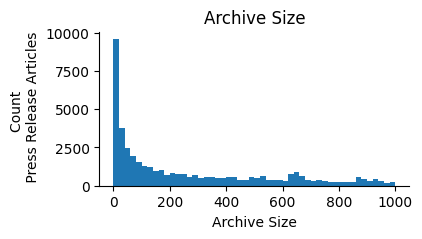

In [220]:
import matplotlib.pyplot as plt
ax = press_release_archive_map['archive_list'].str.len().hist(bins=50, range=(0, 1000), figsize=(4,2))
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Archive Size')
ax.set_ylabel('Count \n Press Release Articles')
ax.set_xlabel('Archive Size')

In [253]:
press_release_archive_map['archive_list_short'].str.len().value_counts()

archive_list_short
10    28422
0     23570
1      6932
2      4225
3      3267
4      2474
5      2142
6      1837
7      1491
8      1283
9      1153
Name: count, dtype: int64

In [258]:
candidates_with_archives = press_release_archive_map.loc[lambda df: df['archive_list_short'].str.len() > 2]

In [276]:
t1 = candidates_with_archives.iloc[0]['press_release_url']
pr_article = pd.read_sql(f'select * from article_data where common_crawl_url = "{t1}"', con=conn)
t2 = t_df.iloc[0]['archive_list_short']
t2 = ', '.join(list(map(lambda x: f'"{x}"', t2)))
target_articles = pd.read_sql(f'select * from article_data where common_crawl_url IN ({t2})', con=conn)

In [277]:
pr_article

,common_crawl_url,article_text,article_publish_date,article_authors,article_top_image,article_scrape_timestamp,source,timestamp_join_key,timestamp,is_press_release_article,is_archival_article
0,"com,barrons)/advisor/articles/com,barrons)/adv...",A 90-year-old Morgan Stanley financial advisor...,None,Kenneth Corbin,https://images.barrons.com/im-529713/social,20221003110924,barrons-business,https://www.barrons.com/advisor/articles/90-ye...,20220705204258,1,0


In [278]:
target_articles

,common_crawl_url,article_text,article_publish_date,article_authors,article_top_image,article_scrape_timestamp,source,timestamp_join_key,timestamp,is_press_release_article,is_archival_article
0,"com,barrons)/advisor/articles/com,barrons)/adv...",Never mind the crypto bear market. Fidelity In...,None,Tom Taulli,https://images.barrons.com/im-638104/social,20230130173454,barrons-business,https://www.barrons.com/advisor/articles/fidel...,20221005200338,0,1
1,"com,barrons)/advisor/articles/com,barrons)/adv...",Responding to what it describes as client inte...,None,Kenneth Corbin,https://images.barrons.com/im-638897/social,20221203123915,barrons-business,https://www.barrons.com/advisor/articles/weeks...,20221007163550,0,1


# Article Links

In [203]:
all_href = pd.read_sql("""SELECT * FROM article_to_href WHERE is_press_release = 1""", con=conn)

In [222]:
all_href = all_href.loc[lambda df: df['is_press_release'] == 1]

In [229]:
article_sample = pd.read_sql("""SELECT * FROM article_data limit 10000""", con=conn)

Text(0.5, 0, 'Link Location (Character Index)')

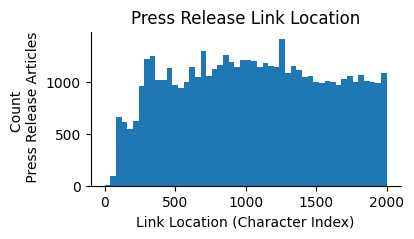

In [236]:
ax = all_href['char_start_idx'].hist(bins=50, range=(0, 2000), figsize=(4,2))
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Press Release Link Location')
ax.set_ylabel('Count \n Press Release Articles')
ax.set_xlabel('Link Location (Character Index)')

In [1]:
import sys
sys.path.insert(0, '../src/')
from augment_retriv import MySparseRetriever
r = MySparseRetriever.load('archive-retriever')

# r.index(index_to_create)

r.search("witches masses", include_id_list=[
    'com,techcrunch)/2018/11/06/com,techcrunch)/2018/11/06/original-content-chilling-sabrina', 
    'com,cnbc)/2018/04/09/com,cnbc)/2018/04/09/trump-vents-against-attorney-general-sessions-in-searing-remarks.html', 
    'com,marketwatch)/press-release/com,marketwatch)/press-release/halloween-spending-to-reach-9-billion-2018-09-20'
])